In [1]:
import pandas as pd
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import colors
from rebound.interruptible_pool import InterruptiblePool

In [2]:
def line(x, a, b):
    return a*x + b

In [3]:
def simulation(param):
    P1, P2 = param
    ecc1, ecc0, ecc2 = 0.003, 0.070, 0.016
    mu1, mu2 = 36e-6, 28e-6
    omega1, omega0, omega2 = -0.4, -0.86, 0
    P_0, lambda_0 = 0.05, 0

    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, omega=omega1)
    sim.add(m=mu2, P=P2, e=ecc2, omega=omega2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc0, omega=omega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    sim.init_megno()
    
    # calculate megno
    time = np.logspace(0,5,num=100)*P_0
    for T in time:
        sim.integrate(T, exact_finish_time=0)
        if sim.calculate_megno() >= 2.5:
            megno = np.zeros(200)
            sim_time = np.linspace(sim.t, 50*sim.t, num=200)
            for i, t in enumerate(sim_time):
                try:
                    sim.integrate(t, exact_finish_time=0)
                    m = sim.calculate_megno()
                    megno[i] = m
                    if m >= 50:
                        break
                except rebound.Collision:
                    break
            y = megno[megno != 0]
            x = sim_time[0:len(y)]
            (popt, pcov) = curve_fit(line, x, y, maxfev=90000)
            ly = 1/popt[0]
            return ly
    return 1e6

In [4]:
Ngrid_x = 100
Ngrid_y = 100
P_0 = 0.05

r10 = np.linspace(0.49,0.76,Ngrid_x)
r20 = np.linspace(1.3,2.04,Ngrid_y)
parameters = [[P_0*x, P_0*y] for x in r10 for y in r20]
results = np.zeros(Ngrid_x*Ngrid_y)

In [ ]:
for i,param in enumerate(parameters):
    try:
        results[i] =simulation(param)
    except:
        print(f'error in round {i}')
        
np.savetxt("lyapunov.csv", results, delimiter=",")

In [5]:
def rescale(results):
    failed = np.zeros(len(results))
    ly_rescaled = np.zeros(len(results))
    for i in range(0,len(results)):
        ly = results[i][0]
        if ly > 0:
            x = round(np.log10(ly/0.05))
            if x > 6:
                ly_rescaled[i] = 7
            else:
                ly_rescaled[i] = x
        else:
            failed[i] = i
            ly_rescaled[i] = 7
    return ly_rescaled, failed[failed != 0]

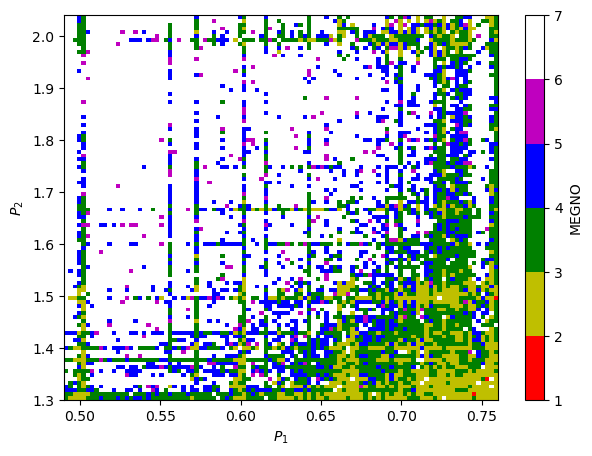

In [6]:
dataframe = pd.read_csv('lyapunov.csv', header=None)
data = dataframe.values
ly_rescaled, fail_index = rescale(data)
results2d = np.array(ly_rescaled).reshape(Ngrid_y,Ngrid_x)

fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(r10),max(r10),min(r20),max(r20)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel(r"$P_1$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel(r"$P_2$")
im = ax.imshow(results2d.transpose(), interpolation="none", vmin=1, vmax=7, cmap=colors.ListedColormap(['r','y','g','b','m','w']), origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO")

In [7]:
fail_index

array([ 203.,  312.,  318.,  320.,  323.,  340.,  361.,  380.,  391.,
        427.,  526.,  903., 1003., 1103., 1501., 1613., 1649., 1803.,
       2105., 2303., 2405., 2426., 2457., 2465., 2474., 2478., 2481.,
       2486., 2603., 2626., 2803., 2904., 3003., 3032., 3045., 3071.,
       3089., 3104., 3225., 3401., 3450., 3482., 3603., 3690., 3703.,
       3713., 3794., 4013., 4038., 4159., 4171., 4179., 4183., 4187.,
       4194., 4226., 4244., 4424., 4493., 4503., 4513., 4526., 4600.,
       4605., 4768., 4803., 4920., 4993., 5103., 5210., 5299., 5631.,
       5705., 5717., 6034., 6202., 6223., 6240., 6303., 6331., 6332.,
       6335., 6339., 6345., 6346., 6347., 6348., 6355., 6356., 6357.,
       6359., 6362., 6364., 6366., 6368., 6370., 6371., 6373., 6377.,
       6378., 6380., 6386., 6387., 6391., 6415., 6416., 6417., 6426.,
       6438., 6512., 6513., 6560., 6605., 6623., 6654., 6730., 6735.,
       6750., 6757., 6761., 6798., 6799., 6827., 6867., 7064., 7101.,
       7284., 7422.,